# CNN   small datasets 학습


- 학습할 Data의 개수가 많지 않을 때 CNN을 통한 모형 학습이 어려울 수 있음
  - 딥러닝은 많은 수의 데이터를 통해 feature engineering 과정 없이 원하는 문제를 해결할 수 있다. => **Point: 많은 데이터 수**
- Data가 많지 않아 CNN 학습에 어려움이 있을 때 사용 가능한 방법
    - Data augmentation 활용
        - 원본 이미지의 색깔, 각도 등을 약간씩 변형한 이미지들을 추가로 만들어 data의 수를 늘림 
    - Pre-trained network의 활용
        - 매우 큰 데이터셋으로 미리 Training한 모델의 파라미터(가중치)를 가져와서 풀려는 문제에 맞게 모델을 재보정해서 사용한다.
        - 성능이 좋은 학습된 모델을 사용하므로 적은 데이터에도 좋은 성능을 낼 수있다.

## Data for cats vs. dogs
- 2013년 Kaggle의 computer vision competition data 활용 https://www.kaggle.com/c/dogs-vs-cats/data
- 개와 고양이를 구분하기 위한 문제로 각 12,500개의 이미지를 포함
- Medium-resolution color JPEGs
- 25000장의 사진 중 4000장의 cats/dogs 사진(2000 cats, 2000 dogs) 만을 사용하여 학습하여 좋은 모형을 만들어 낼 수 있을까?
    - 학습: 2000, 검증: 1000, 테스트: 1000
    
![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

##### 이미지 다운로드
- gdown 패키지 : 구글 드라이브의 공유파일 다운로드 패키지    
- `pip install gdown`
- 코랩에는 설치 되어 있음.

In [3]:
import gdown

url = 'https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU'
fname = 'cats_and_dogs_small.zip'

gdown.download(url, fname, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1nBE3N2cXQGwD8JaD0JZ2LmFD-n3D5hVU
To: /content/cats_and_dogs_small.zip
100%|██████████| 90.8M/90.8M [00:00<00:00, 272MB/s]


'cats_and_dogs_small.zip'

In [4]:
import os
#zipfile모듈: Zip 압축파일을 다루는 모듈(압축하기, 풀기)
from zipfile import ZipFile

# 압축풀기: ZipFile(압축파일경로).extractall(풀경로)
with ZipFile(fname) as zipFile:
    zipFile.extractall(os.path.join('data','cats_and_dogs_small'))

# 하이퍼파라미터 정의

In [5]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224   # 모든 이미지데이터를 224, 224 로 resize해서 학습 시킬 것임.

## 모델 구현 및 학습

- Input: $224 \times 224$ 픽셀의 RGB layer 
- Output: cat or dog (binary classification)  
- ImageDataGenerator를 이용해 파일시스템에 저장된 이미지 데이터셋을 학습시킨다.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

In [7]:
def create_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu',
                            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(layers.MaxPool2D(padding="same")) #pool_size=(2,2), strides=(2,2) -> 절반으로 축소

    model.add(layers.Conv2D(filters=64, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    model.add(layers.Conv2D(filters=128, kernel_size=3, padding="same", activation='relu'))
    model.add(layers.MaxPool2D(padding='same'))

    
    model.add(layers.Flatten())
    
    model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(units=512, activation='relu'))
    # 출력 Layer (cats/dogs => dogs 일 확률을 출력하는 이진분류)
    model.add(layers.Dense(units=1, activation='sigmoid'))

    return model

# ImageDataGenerator 생성

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_dir = "data/cats_and_dogs_small/train"
valid_dir = "data/cats_and_dogs_small/validation"
test_dir = "data/cats_and_dogs_small/test"

In [10]:
# image augmentation을 적용하지 않고 학습.
# ImageDataGenerator: 파이프라인 처리방식 설정.
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
# ImageDataGenerator.flow_from_directory() : Image데이터 읽어오는 설정.
train_iter = train_datagen.flow_from_directory(train_dir,   #읽을 디렉토리 경로
                                               target_size=(IMAGE_SIZE, IMAGE_SIZE), #리사이즈
                                               class_mode='binary',  # 이진분류
                                               batch_size=N_BATCHS   # 배치크기
                                               )

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                              class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# iterator.class_indices : class와 class name을 알려준다.
train_iter.class_indices

{'cats': 0, 'dogs': 1}

In [ ]:
# 에폭당 step 수를 조회
len(train_iter), len(valid_iter), len(test_iter)

(25, 13, 13)

In [ ]:
# 배치크기만큼 데이터를 조회
batch = next(train_iter)
print(type(batch)) 
# 반환타입: 튜플 (X, y)
print(type(batch[0]), type(batch[1]))
print(batch[0].shape, batch[1].shape)

<class 'tuple'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(80, 224, 224, 3) (80,)


In [ ]:
batch[1][:10]

array([1., 1., 1., 1., 1., 0., 1., 1., 0., 1.], dtype=float32)

In [ ]:
import numpy as np
# 1/225 롤 rescale했기 때문에 0 ~ 1 으로 정규화
np.min(batch[0][0]), np.max(batch[0][0])

(0.0, 1.0)

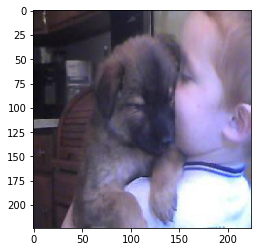

In [ ]:
# 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(batch[0][4])
plt.show()

In [ ]:
# 모델 생성
model = create_model()
# 컴파일
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)      0

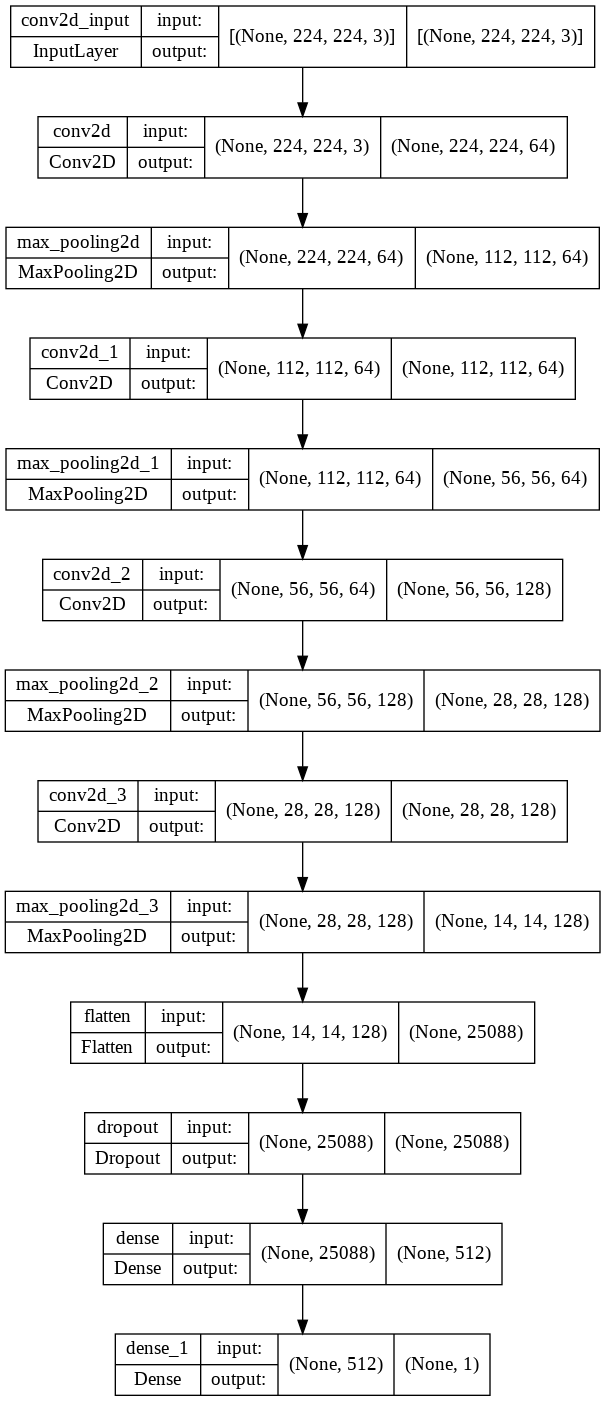

In [ ]:
keras.utils.plot_model(model, show_shapes=True)


##  Model Training(학습)

In [ ]:
!rm -r drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# 모델을 저장할 디렉토리 (callback 을 이용해서 best 모델을 저장할 예정.)
#   구글드라이브 경로(/content/drive/MyDrive)에 저장.
save_dir = os.path.join("/content/drive/MyDrive/saved_models", "cat_dog_model", "basic")
print(save_dir)
# 디렉토리 생성
os.makedirs(save_dir, exist_ok=True)

/content/drive/MyDrive/saved_models/cat_dog_model/basic


In [ ]:
# 모델 weight를 저장할 파일경로
save_file_path = os.path.join(save_dir, "weights_ckpt")
# 학습 도중 모델을 저장하는 callback
mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True,   # 모델의 weight만 저장
                                              save_best_only=True, # 모델 성능이 개선된 epoch만 저장
                                              monitor='val_loss', # 성능개선 지표로 확인할 평가지표
                                              verbose=2)
# 조기종료 callback. 성능개선이 안된면 학습을 종료
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            patience=5,
                                            verbose=1)

In [ ]:
# ImageDataGenerator를 train/validation set으로 사용할 경우
#    steps_per_epoch: 1epoch 당 step 수
#    validation_steps: 검증 횟수(validation set을 몇개로 나눠서 검증할 지 횟수.) 
hist = model.fit(train_iter, 
                 epochs=N_EPOCHS, 
                 steps_per_epoch=len(train_iter),
                 validation_data=valid_iter, 
                 validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.4955
Epoch 1: val_loss improved from inf to 0.69286, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/basic/weights_ckpt
25/25 [==============================] - 27s 526ms/step - loss: 0.7199 - accuracy: 0.4955 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.4985
Epoch 2: val_loss improved from 0.69286 to 0.69262, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/basic/weights_ckpt
25/25 [==============================] - 11s 448ms/step - loss: 0.6936 - accuracy: 0.4985 - val_loss: 0.6926 - val_accuracy: 0.6030
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.5355
Epoch 3: val_loss did not improve from 0.69262
25/25 [==============================] - 11s 419ms/step - loss: 0.6887 - accuracy: 0.5355 - val_loss: 0.6955 - val_accuracy: 0.5000
Ep

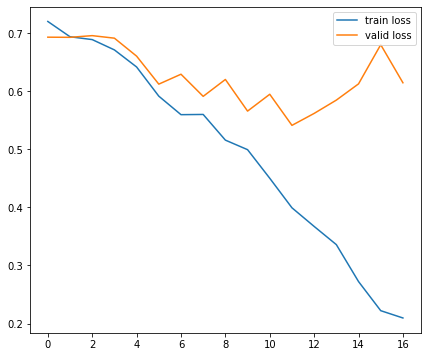

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='valid loss')
plt.legend()
plt.show()

##### 저장된 모델 조회

In [ ]:
# 파라미터만 저장한 경우
# 1. 모델을 생성  2. 생성된 모델의 파라미터를 저장한 파라미터로 변환.

save_model = create_model()
save_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [ ]:
save_model.evaluate(test_iter)

13/13 [==============================] - 15s 276ms/step - loss: 0.6929 - accuracy: 0.5110


[0.6928682923316956, 0.5109999775886536]

In [ ]:
save_model.load_weights(save_file_path)

In [ ]:
save_model.evaluate(test_iter)

13/13 [==============================] - 3s 260ms/step - loss: 0.5664 - accuracy: 0.7160


[0.566394567489624, 0.7160000205039978]

# 새로운 데이터 추론

In [12]:
# 1. 이미지 파일 읽어오기.
# 2. resize (모델의 입력 shape 맞게) - 224
# 3. 전처리: 정규화 (1/255)

from tensorflow.keras.preprocessing.image import load_img, img_to_array
def load_preprocess_image(img_path):
    """
    img_path 이미지를 읽어서 추론할 수있는 ndarray로 변환해서 반환하는 함수
    """
    # 이미지파일 읽기 - target_size=(height, width) : 읽어오면서 resize
    raw_img = load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
    img_array = img_to_array(raw_img) # Pillow Image객체 -> ndarray 변환
    img_array = img_array[np.newaxis, ...] #batch axis 추가
    img_array = img_array.astype(np.float32) # uint8 -> float32 타입변환
    return img_array/255.0  #0~1 사이 실수로 정규화.


In [ ]:
dog = load_preprocess_image('dog.jpg')
cat = load_preprocess_image('cat.jpg')
dog2 = load_preprocess_image('dog2.jpg')
dog.shape, cat.shape

((1, 224, 224, 3), (1, 224, 224, 3))

In [ ]:
pred1 = save_model.predict(dog)
pred2 = save_model.predict(cat)
pred3 = save_model.predict(dog2)

In [ ]:
# 1(dog)일 확률 추론.
print(pred1)
print(pred2)
print(pred3)

[[0.80020744]]
[[0.16767031]]
[[0.5911352]]


In [ ]:
print(pred1)
result1 = np.where(pred1>0.5, '개', '고양이')[0]
result1

[[0.80020744]]


array(['개'], dtype='<U3')

In [ ]:
print(pred2)
result2 = np.where(pred2>0.5, '개', '고양이')[0]
result2


[[0.16767031]]


array(['고양이'], dtype='<U3')

In [ ]:
print(pred3)
result3 = np.where(pred3>0.5, '개', '고양이')[0]
result3

[[0.5911352]]


array(['개'], dtype='<U3')

In [ ]:
train_iter.class_indices

# Using data augmentation

- 학습 이미지의 수가 적어서 overfitting이 발생할 가능성을 줄이기 위해 기존 훈련 데이터로부터 그럴듯하게 이미지 변환을 통해서 이미지(데이터)를 늘리는 작업을 Image augmentation
- train_set에만 적용, validation, test set에는 적용하지 않는다. (rescaling만 한다.)

In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

np.random.seed(0)
tf.random.set_seed(0)

##### 하이파러파미터

In [14]:
LEARNING_RATE = 0.001
N_EPOCHS = 100
N_BATCHS = 80

IMAGE_SIZE = 224

##### ImageDataGenerator 생성

In [15]:
train_dir = 'data/cats_and_dogs_small/train'
valid_dir = 'data/cats_and_dogs_small/validation'
test_dir = 'data/cats_and_dogs_small/test'

In [16]:
train_datagen = ImageDataGenerator(rescale=1/255.0, 
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2, 
                                   horizontal_flip=True,
                                   fill_mode='constant'
                                   )

valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)


In [17]:
train_iter = train_datagen.flow_from_directory(train_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

valid_iter = valid_datagen.flow_from_directory(valid_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                               class_mode='binary', batch_size=N_BATCHS)

test_iter = test_datagen.flow_from_directory(test_dir, target_size=(IMAGE_SIZE, IMAGE_SIZE), 
                                                class_mode='binary', batch_size=N_BATCHS)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
batch_samples = next(train_iter)
len(batch_samples), type(batch_samples) # tuple (X, y)

(2, tuple)

In [ ]:
batch_image_sample = batch_samples[0]
batch_image_sample.shape, batch_image_sample.dtype

((80, 224, 224, 3), dtype('float32'))

In [ ]:
plt.figure(figsize=(30,15))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(batch_image_sample[i])
    plt.title(str(batch_samples[1][i]))

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

##### 모델 생성, 컴파일, 학습

In [ ]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
              loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
save_dir = os.path.join("/content/drive/MyDrive/saved_models/cat_dog_model", "augmentation")
os.makedirs(save_dir, exist_ok=True)

save_file_path = os.path.join(save_dir, 'weights_ckpt')

In [ ]:

mc_callback = keras.callbacks.ModelCheckpoint(filepath=save_file_path, 
                                              save_weights_only=True, 
                                              save_best_only=True, 
                                              monitor='val_loss', 
                                              verbose=2)

es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2)

In [ ]:
hist = model.fit(train_iter, epochs=N_EPOCHS, steps_per_epoch=len(train_iter), 
                 validation_data=valid_iter, validation_steps=len(valid_iter),
                 callbacks=[mc_callback, es_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.5105
Epoch 1: val_loss improved from inf to 0.69218, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt
25/25 [==============================] - 30s 1s/step - loss: 0.7564 - accuracy: 0.5105 - val_loss: 0.6922 - val_accuracy: 0.5000
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5100
Epoch 2: val_loss improved from 0.69218 to 0.69091, saving model to /content/drive/MyDrive/saved_models/cat_dog_model/augmentation/weights_ckpt
25/25 [==============================] - 29s 1s/step - loss: 0.6929 - accuracy: 0.5100 - val_loss: 0.6909 - val_accuracy: 0.5080
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.5405
Epoch 3: val_loss did not improve from 0.69091
25/25 [==============================] - 27s 1s/step - loss: 0.6920 - accuracy: 0.5405 - val_loss: 0.6924 - val_accuracy: 0.50

##### 저장된 모델 Loading 후 평가(사용)

In [21]:
# 모델 생성 (weight만 저장했으므로 모델 생성후 저장된 weight로 변경.)
saved_model_aug = create_model()
saved_model_aug.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])
# 모델에 저장된 weight를 덮어씌우기.(변경)
saved_model_aug.load_weights(save_file_path)

In [22]:
saved_model_aug.evaluate(test_iter)

13/13 [==============================] - 15s 264ms/step - loss: 0.4621 - accuracy: 0.8090


[0.46205464005470276, 0.8090000152587891]

##### 새로운데이터 추론

In [23]:
dog2 = load_preprocess_image('dog.jpg')
cat2 = load_preprocess_image('cat.jpg')
dog3 = load_preprocess_image('image.jpg')

pred3 = saved_model_aug.predict(dog2)
pred4 = saved_model_aug.predict(cat2)
pred5 = saved_model_aug.predict(dog3)

In [24]:
print(pred3)
print(pred4)
print(pred5)

[[0.8428945]]
[[0.35543177]]
[[0.70271975]]


In [25]:
print(np.where(pred3>0.5, '개', '고양이'))

[['개']]
